### **IMPORT**

In [ ]:
from keras import backend as K


import copy
from tensorflow.keras import optimizers
import keras
import numpy as np
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers import SpatialDropout2D
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf


### **DROPBLOCK FUNCTION**
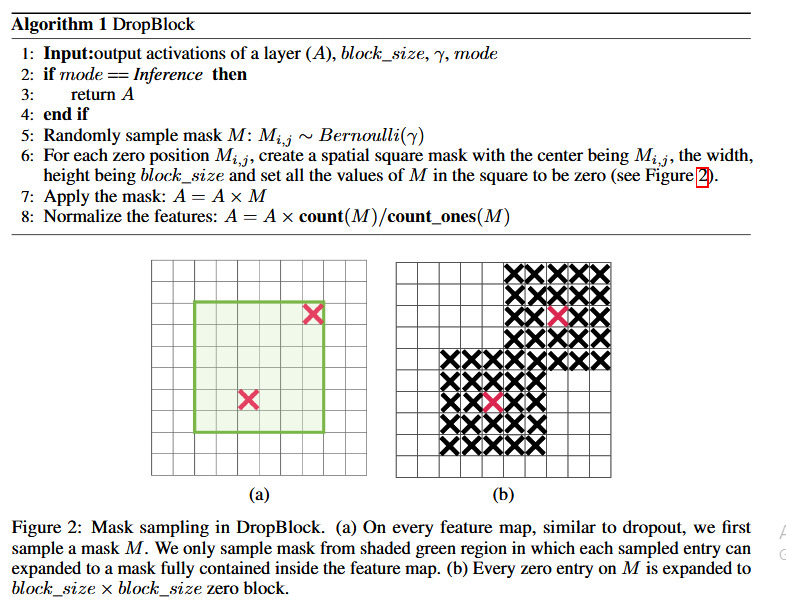


In [ ]:
from keras import backend as K


import copy

class NN_DropBlock(tf.keras.layers.Layer):

    def __init__(self, block_size, keep_prob, **kwargs):
        super(NN_DropBlock, self).__init__(**kwargs)
        self.block_size = block_size
        self.keep_prob = keep_prob

    def call(self, x, inference=None):

        # During inference, we do not Drop Blocks
        if inference == None:
            return x

        #padding
        z = self.block_size//2

        # Calculate Gamma
        feature_size = int(x.shape[-1])
        gamma = ((1-self.keep_prob)/(self.block_size**2)) * ((feature_size**2) / ((feature_size-self.block_size+1)**2))

        # Randomly sample mask
        sample_mask = tf.nn.relu(tf.sign(gamma - tf.random_uniform((feature_size-(z*2), feature_size-(z*2)), minval=0, maxval=1, dtype=tf.float32)))

        # The above code creates a matrix of zeros and samples ones from the distribution
        # We would like to flip all of these values
        sample_mask = 1-sample_mask

        # Pad the mask with ones
        sample_mask = np.pad(sample_mask, pad_width=z, mode='constant', constant_values=1)

        # For each 0, create spatial square mask of shape (block_size x block_size)
        spatial_square_mask = copy.copy(sample_mask)
        for i in range(feature_size):
            for j in range(feature_size):
                if sample_mask[i, j]==0:
                    spatial_square_mask[i-z : i+z+1, j-z : j+z+1] = 0

        spatial_square_mask = spatial_square_mask.reshape((1, feature_size, feature_size))

        # Apply the mask
        x = x * np.repeat(spatial_square_mask, x.shape[1], 0)

        # Normalize the features
        count = np.prod(spatial_square_mask.shape)
        count_ones = np.count_nonzero(spatial_square_mask == 1)
        x = x * count / count_ones

        return x

    def get_config(self):
        config = {'block_size': self.block_size,
                  'keep_prob': self.keep_prob
                  }
        base_config = super(NN_DropBlock, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

### **CALLBACK FUNCTION**

In [ ]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch,logs={}):
        # vary the rate wrt epochs. That's what you want
        self.model.get_layer(name = 'Drop1').keep_prob -= 0.008
        # vary the rate wrt epochs. That's what you want
        self.model.get_layer(name = 'Drop2').keep_prob -= 0.008
        # vary the rate wrt epochs. That's what you want
        self.model.get_layer(name = 'Drop2').keep_prob -= 0.008

### **CNN Standard**

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)   

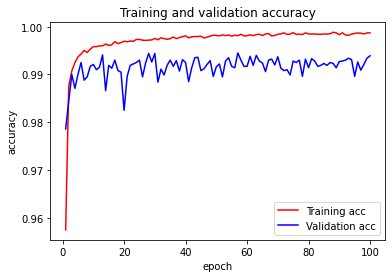

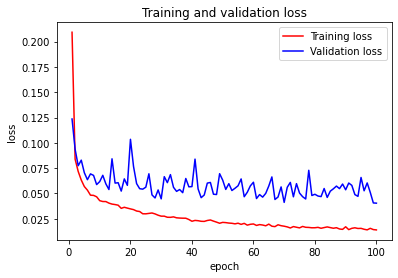

In [ ]:
batch_size = 128
epochs = 100
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc1 = history.history['accuracy']
val_acc1 = history.history['val_accuracy']
loss1 = history.history['loss']
val_loss1 = history.history['val_loss']

print(acc1)
print(val_acc1)
print(loss1)
print(val_loss1)

epochs = range(1, len(acc1) + 1)

plt.plot(epochs, acc1, 'r', label='Training acc')
plt.plot(epochs, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss1, 'r', label='Training loss')
plt.plot(epochs, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPOUT(0.25)**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
activation_6 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 32)        128       
_______________________________________________

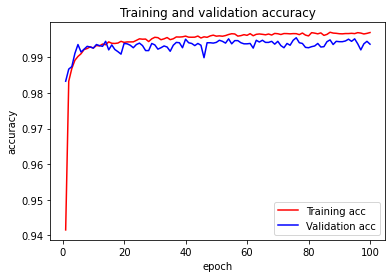

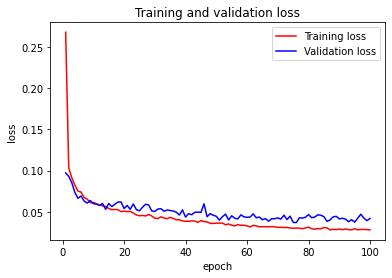

In [ ]:
batch_size = 128
epochs = 100
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Dropout(0.25))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc2 = history.history['accuracy']
val_acc2 = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss2 = history.history['val_loss']

print(acc2)
print(val_acc2)
print(loss2)
print(val_loss2)

epochs = range(1, len(acc2) + 1)

plt.plot(epochs, acc2, 'r', label='Training acc')
plt.plot(epochs, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss2, 'r', label='Training loss')
plt.plot(epochs, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **SPATIALDROPOUT(0.7)**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_12 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 28, 28, 32)        128       
_______________________________________________

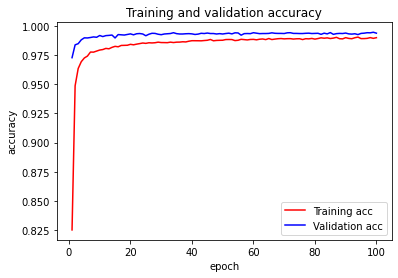

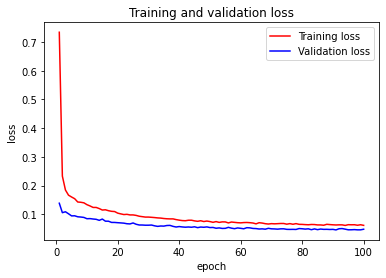

In [ ]:
batch_size = 128
epochs = 100
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(SpatialDropout2D(0.7))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(SpatialDropout2D(0.7))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(SpatialDropout2D(0.7))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc3 = history.history['accuracy']
val_acc3 = history.history['val_accuracy']
loss3 = history.history['loss']
val_loss3 = history.history['val_loss']

print(acc3)
print(val_acc3)
print(loss3)
print(val_loss3)

epochs = range(1, len(acc3) + 1)

plt.plot(epochs, acc3, 'r', label='Training acc')
plt.plot(epochs, val_acc3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss3, 'r', label='Training loss')
plt.plot(epochs, val_loss3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPBLOCK**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_22 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_23 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 28, 28, 32)        128       
_______________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:6068: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  warnings.warn('`tf.keras.backend.random_binomial` is deprecated, '


469/469 [==============================] - 23s 40ms/step - loss: 0.5803 - accuracy: 0.8872 - val_loss: 0.1093 - val_accuracy: 0.9834
Epoch 2/100
469/469 [==============================] - 19s 40ms/step - loss: 0.0906 - accuracy: 0.9864 - val_loss: 0.1167 - val_accuracy: 0.9811
Epoch 3/100
469/469 [==============================] - 19s 40ms/step - loss: 0.0761 - accuracy: 0.9902 - val_loss: 0.0899 - val_accuracy: 0.9868
Epoch 4/100
469/469 [==============================] - 18s 39ms/step - loss: 0.0697 - accuracy: 0.9916 - val_loss: 0.0710 - val_accuracy: 0.9910
Epoch 5/100
469/469 [==============================] - 19s 40ms/step - loss: 0.0623 - accuracy: 0.9931 - val_loss: 0.0762 - val_accuracy: 0.9887
Epoch 6/100
469/469 [==============================] - 19s 40ms/step - loss: 0.0558 - accuracy: 0.9944 - val_loss: 0.0696 - val_accuracy: 0.9903
Epoch 7/100
469/469 [==============================] - 19s 40ms/step - loss: 0.0510 - accuracy: 0.9949 - val_loss: 0.0665 - val_accuracy: 0.99

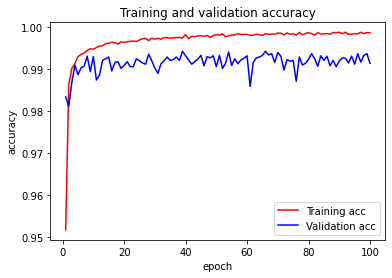

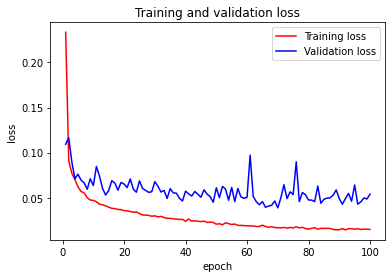

In [ ]:
batch_size = 128
epochs = 100
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=3, keep_prob=0.9, name = 'Drop1'))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=3, keep_prob=0.9, name = 'Drop2'))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=3, keep_prob=0.9, name = 'Drop3'))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc4 = history.history['accuracy']
val_acc4 = history.history['val_accuracy']
loss4 = history.history['loss']
val_loss4 = history.history['val_loss']

print(acc4)
print(val_acc4)
print(loss4)
print(val_loss4)

epochs = range(1, len(acc4) + 1)

print(epochs)

plt.plot(epochs, acc4, 'r', label='Training acc')
plt.plot(epochs, val_acc4, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss4, 'r', label='Training loss')
plt.plot(epochs, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **DROPBLOCK 7**

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py:376: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return py_builtins.overload_of(f)(*args)


469/469 [==============================] - 74s 46ms/step - loss: 0.6349 - accuracy: 0.8841 - val_loss: 0.0921 - val_accuracy: 0.9860
Epoch 2/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0961 - accuracy: 0.9851 - val_loss: 0.1288 - val_accuracy: 0.9795
Epoch 3/100
469/469 [==============================] - 20s 44ms/step - loss: 0.0786 - accuracy: 0.9894 - val_loss: 0.0891 - val_accuracy: 0.9875
Epoch 4/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0686 - accuracy: 0.9917 - val_loss: 0.0774 - val_accuracy: 0.9908
Epoch 5/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0572 - accuracy: 0.9946 - val_loss: 0.1043 - val_accuracy: 0.9845
Epoch 6/100
469/469 [==============================] - 21s 44ms/step - loss: 0.0568 - accuracy: 0.9938 - val_loss: 0.0626 - val_accuracy: 0.9919
Epoch 7/100
469/469 [==============================] - 20s 43ms/step - loss: 0.0543 - accuracy: 0.9940 - val_loss: 0.0703 - val_accuracy: 0.99

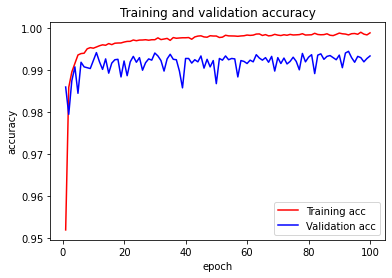

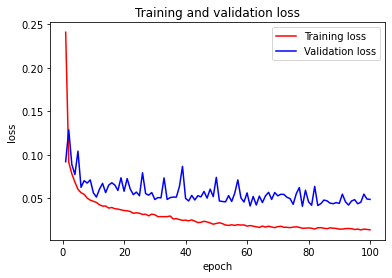

In [ ]:
batch_size = 128
epochs = 100
num_classes = 10

# input image dimension
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first': # I want this shape: num_samples x 1 x 28 x 28
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else: # I want this shape: num_samples x 28 x 28 x 1
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

weight_decay = 1e-4

model2 = Sequential()

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=input_shape))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=7, keep_prob=0.9, name = 'Drop1'))
 
model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=7, keep_prob=0.9, name = 'Drop2'))

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())

model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(NN_DropBlock(block_size=7, keep_prob=0.9, name = 'Drop3'))
 
model2.add(Flatten())
model2.add(Dense(num_classes, activation='softmax'))
 
model2.summary()

opt_rms = optimizers.RMSprop(lr=0.001,decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

history = model2.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks = myCallback())

# Score trained model.
scores = model2.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

acc5 = history.history['accuracy']
val_acc5 = history.history['val_accuracy']
loss5 = history.history['loss']
val_loss5 = history.history['val_loss']

print(acc5)
print(val_acc5)
print(loss5)
print(val_loss5)

epochs = range(1, len(acc5) + 1)

print(epochs)

plt.plot(epochs, acc5, 'r', label='Training acc')
plt.plot(epochs, val_acc5, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()

plt.figure()

plt.plot(epochs, loss5, 'r', label='Training loss')
plt.plot(epochs, val_loss5, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

### **MERGE RESULTS**

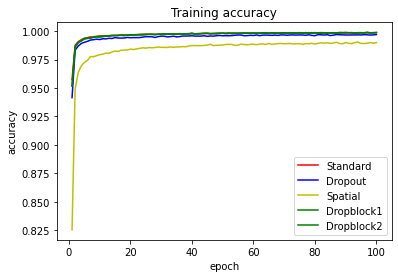

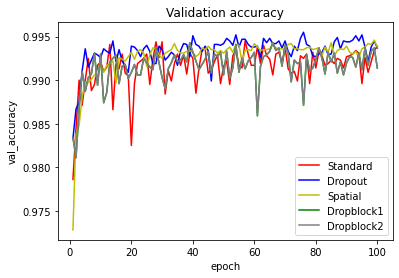

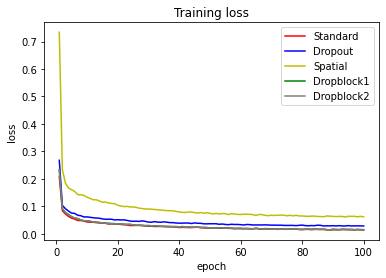

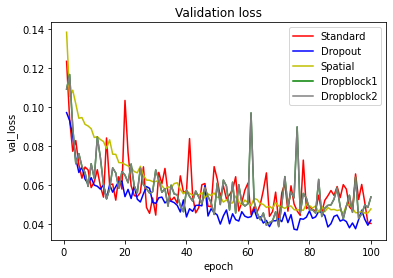

In [ ]:
acc1 = [0.9574666619300842, 0.9875500202178955, 0.9907333254814148, 0.9924499988555908, 0.9936833381652832, 0.9942666888237, 0.995033323764801, 0.9945999979972839, 0.9952999949455261, 0.9958166480064392, 0.9958166480064392, 0.995983362197876, 0.995983362197876, 0.9963833093643188, 0.9960833191871643, 0.9962000250816345, 0.9968666434288025, 0.9964500069618225, 0.996666669845581, 0.9969499707221985, 0.9968500137329102, 0.9969833493232727, 0.9969499707221985, 0.9973166584968567, 0.9973333477973938, 0.9971666932106018, 0.9971333146095276, 0.9971833229064941, 0.9972333312034607, 0.9975333213806152, 0.9972666501998901, 0.9976666569709778, 0.9975000023841858, 0.9973666667938232, 0.9974833130836487, 0.9978500008583069, 0.9975000023841858, 0.9977166652679443, 0.9979166388511658, 0.9980833530426025, 0.9976666569709778, 0.997866690158844, 0.99795001745224, 0.9979333281517029, 0.9980000257492065, 0.9976166486740112, 0.9978166818618774, 0.998033344745636, 0.9982166886329651, 0.9981666803359985, 0.9980833530426025, 0.9982666373252869, 0.9981333613395691, 0.9982500076293945, 0.9980166554450989, 0.9982166886329651, 0.998116672039032, 0.9984166622161865, 0.9980666637420654, 0.9980999827384949, 0.9983000159263611, 0.998116672039032, 0.9983333349227905, 0.9984166622161865, 0.9981499910354614, 0.9984666705131531, 0.9985499978065491, 0.9980499744415283, 0.9981666803359985, 0.9983999729156494, 0.9984999895095825, 0.9987000226974487, 0.9983999729156494, 0.9984333515167236, 0.9987499713897705, 0.9983833432197571, 0.9984333515167236, 0.9983500242233276, 0.9987000226974487, 0.9984833598136902, 0.998449981212616, 0.9984833598136902, 0.9984166622161865, 0.9983999729156494, 0.9984666705131531, 0.9984333515167236, 0.9985166788101196, 0.9988333582878113, 0.9987000226974487, 0.9983166456222534, 0.9987166523933411, 0.9982666373252869, 0.998199999332428, 0.9984333515167236, 0.9986000061035156, 0.9986666440963745, 0.9986333250999451, 0.9984833598136902, 0.9986833333969116, 0.9987000226974487]
val_acc1 = [0.978600025177002, 0.984499990940094, 0.9900000095367432, 0.9871000051498413, 0.9900000095367432, 0.9925000071525574, 0.9887999892234802, 0.9894999861717224, 0.9916999936103821, 0.9921000003814697, 0.9909999966621399, 0.9915000200271606, 0.9940999746322632, 0.9865999817848206, 0.9919000267982483, 0.9912999868392944, 0.9929999709129333, 0.9908000230789185, 0.9904999732971191, 0.9825000166893005, 0.9896000027656555, 0.9919000267982483, 0.9922000169754028, 0.9925000071525574, 0.9929999709129333, 0.9894999861717224, 0.9923999905586243, 0.9944000244140625, 0.9926000237464905, 0.9944000244140625, 0.9883999824523926, 0.991100013256073, 0.9898999929428101, 0.9919000267982483, 0.9929999709129333, 0.9916999936103821, 0.992900013923645, 0.9907000064849854, 0.9930999875068665, 0.9925000071525574, 0.9884999990463257, 0.9914000034332275, 0.9934999942779541, 0.9936000108718872, 0.9908000230789185, 0.9911999702453613, 0.9921000003814697, 0.992900013923645, 0.9896000027656555, 0.991599977016449, 0.9922000169754028, 0.9894999861717224, 0.9927999973297119, 0.9934999942779541, 0.9916999936103821, 0.9914000034332275, 0.9944999814033508, 0.9929999709129333, 0.9916999936103821, 0.9916999936103821, 0.9937999844551086, 0.9919000267982483, 0.9940000176429749, 0.9927999973297119, 0.9923999905586243, 0.9905999898910522, 0.9929999709129333, 0.9932000041007996, 0.9919999837875366, 0.9937000274658203, 0.9912999868392944, 0.9908000230789185, 0.9909999966621399, 0.9898999929428101, 0.9927999973297119, 0.9925000071525574, 0.9929999709129333, 0.9896000027656555, 0.9932000041007996, 0.9914000034332275, 0.9933000206947327, 0.9927999973297119, 0.9916999936103821, 0.9919000267982483, 0.9922999739646912, 0.9919000267982483, 0.9925000071525574, 0.9922999739646912, 0.9914000034332275, 0.9926999807357788, 0.9927999973297119, 0.9929999709129333, 0.993399977684021, 0.9930999875068665, 0.9896000027656555, 0.9926000237464905, 0.9908999800682068, 0.9921000003814697, 0.993399977684021, 0.9939000010490417]
loss1 = [0.20920142531394958, 0.08382994681596756, 0.07175236940383911, 0.06323593854904175, 0.05683314800262451, 0.053267184644937515, 0.04828828200697899, 0.048090606927871704, 0.04670204967260361, 0.04287269338965416, 0.042038582265377045, 0.041987549513578415, 0.04046107083559036, 0.03949173167347908, 0.0390334278345108, 0.038408562541007996, 0.035301774740219116, 0.03634629771113396, 0.035522691905498505, 0.03475397080183029, 0.03404005616903305, 0.0326419323682785, 0.03214743360877037, 0.029926203191280365, 0.02988673374056816, 0.030292818322777748, 0.030711760744452477, 0.029795296490192413, 0.02850445546209812, 0.02757333591580391, 0.02757207676768303, 0.026494767516851425, 0.026421191170811653, 0.026876479387283325, 0.025942130014300346, 0.025699686259031296, 0.02557118982076645, 0.025543373078107834, 0.02426554448902607, 0.022538242861628532, 0.023371929302811623, 0.023088406771421432, 0.022508615627884865, 0.022391831502318382, 0.02330947108566761, 0.02380198985338211, 0.022689029574394226, 0.021677415817975998, 0.020565733313560486, 0.021433982998132706, 0.021201396360993385, 0.020759189501404762, 0.020534701645374298, 0.01998484693467617, 0.02061537280678749, 0.019470330327749252, 0.02045493572950363, 0.018706858158111572, 0.01953641138970852, 0.019878748804330826, 0.01842084713280201, 0.019242987036705017, 0.018817158415913582, 0.018059737980365753, 0.019699757918715477, 0.01765422336757183, 0.0172431580722332, 0.0190634336322546, 0.01814909651875496, 0.017649957910180092, 0.01697073131799698, 0.015899337828159332, 0.01728590577840805, 0.016627700999379158, 0.016001414507627487, 0.017427043989300728, 0.01657876931130886, 0.016443459317088127, 0.016087807714939117, 0.016140703111886978, 0.016521058976650238, 0.015619756653904915, 0.016303913667798042, 0.01694490946829319, 0.016283508390188217, 0.015643784776329994, 0.016173746436834335, 0.014909917488694191, 0.014535029418766499, 0.01709313876926899, 0.014279311522841454, 0.015563096851110458, 0.016093675047159195, 0.015413947403430939, 0.015536904335021973, 0.014632460661232471, 0.014044414274394512, 0.01556924544274807, 0.01432480476796627, 0.013990228064358234]
val_loss1 = [0.1235227882862091, 0.09363419562578201, 0.07740139216184616, 0.08288304507732391, 0.07046179473400116, 0.06359132379293442, 0.06932993233203888, 0.06781769543886185, 0.05876268446445465, 0.06171156093478203, 0.06792090088129044, 0.05947982147336006, 0.05387602373957634, 0.08421442657709122, 0.060232628136873245, 0.06058444082736969, 0.05233503505587578, 0.06438426673412323, 0.058011494576931, 0.10346832126379013, 0.07664350420236588, 0.059720780700445175, 0.05469057708978653, 0.05425071343779564, 0.05618796497583389, 0.06942927092313766, 0.04859638959169388, 0.04556205868721008, 0.05345793440937996, 0.044661857187747955, 0.0665806233882904, 0.06067950278520584, 0.06860071420669556, 0.056073565036058426, 0.052053190767765045, 0.05386616662144661, 0.05073769763112068, 0.06478024274110794, 0.056537531316280365, 0.05678324028849602, 0.08390354365110397, 0.05447862669825554, 0.04582226648926735, 0.048487622290849686, 0.06020944193005562, 0.06085538864135742, 0.04925423488020897, 0.04895177483558655, 0.06951717287302017, 0.06317653506994247, 0.053980644792318344, 0.059662915766239166, 0.05290190503001213, 0.055109456181526184, 0.057569004595279694, 0.06433536112308502, 0.046765830367803574, 0.05117347836494446, 0.05749288201332092, 0.06106150522828102, 0.04497692361474037, 0.04889083653688431, 0.04637359827756882, 0.05008597671985626, 0.05737690255045891, 0.0663105919957161, 0.04402080550789833, 0.046485740691423416, 0.05644312873482704, 0.04117900878190994, 0.056068964302539825, 0.06089334562420845, 0.046690601855516434, 0.059683866798877716, 0.050360579043626785, 0.0468142107129097, 0.04453027620911598, 0.07287030667066574, 0.047981686890125275, 0.049195099622011185, 0.04746098816394806, 0.04689275100827217, 0.05487842857837677, 0.04609992727637291, 0.05224348604679108, 0.054589323699474335, 0.05727018415927887, 0.05476563796401024, 0.05930216610431671, 0.05363805592060089, 0.06028147414326668, 0.05799068510532379, 0.04887295141816139, 0.04714404046535492, 0.06578221172094345, 0.05263581499457359, 0.060386884957551956, 0.051060907542705536, 0.04063212126493454, 0.040412724018096924]

acc2 = [0.9415500164031982, 0.983299970626831, 0.9868666529655457, 0.9891666769981384, 0.9902499914169312, 0.991016685962677, 0.9922000169754028, 0.9924833178520203, 0.9929500222206116, 0.9926166534423828, 0.9933333396911621, 0.9932000041007996, 0.9937333464622498, 0.9935333132743835, 0.994350016117096, 0.9939500093460083, 0.9939000010490417, 0.9940166473388672, 0.9944999814033508, 0.9941999912261963, 0.9943333268165588, 0.9943333268165588, 0.994350016117096, 0.9947666525840759, 0.995199978351593, 0.9951000213623047, 0.9951333403587341, 0.9944333434104919, 0.995199978351593, 0.9956333041191101, 0.9955333471298218, 0.994949996471405, 0.995199978351593, 0.9955666661262512, 0.9949666857719421, 0.9952166676521301, 0.9957333207130432, 0.9957000017166138, 0.9957666397094727, 0.9959666728973389, 0.9956666827201843, 0.9956499934196472, 0.9956666827201843, 0.995983362197876, 0.9954333305358887, 0.9957666397094727, 0.9956333041191101, 0.9960166811943054, 0.996233344078064, 0.9959499835968018, 0.9960333108901978, 0.9959333539009094, 0.9961166381835938, 0.9964166879653931, 0.9966333508491516, 0.996566653251648, 0.9959666728973389, 0.9961000084877014, 0.9963666796684265, 0.9961833357810974, 0.996649980545044, 0.996066689491272, 0.9964666962623596, 0.996566653251648, 0.9964666962623596, 0.9963333606719971, 0.9965500235557556, 0.9962666630744934, 0.9967166781425476, 0.9966333508491516, 0.9964166879653931, 0.9966833591461182, 0.996666669845581, 0.9965999722480774, 0.996666669845581, 0.996649980545044, 0.9963833093643188, 0.996833324432373, 0.9962499737739563, 0.9960166811943054, 0.9969333410263062, 0.9968000054359436, 0.9965999722480774, 0.9968666434288025, 0.9961666464805603, 0.9964500069618225, 0.9970499873161316, 0.9968166947364807, 0.996749997138977, 0.9966333508491516, 0.9965999722480774, 0.9966833591461182, 0.9966833591461182, 0.996749997138977, 0.996666669845581, 0.9969333410263062, 0.9968166947364807, 0.996566653251648, 0.9967333078384399, 0.9969666600227356]
val_acc2 = [0.983299970626831, 0.9866999983787537, 0.9873999953269958, 0.991100013256073, 0.9936000108718872, 0.9915000200271606, 0.9922999739646912, 0.9930999875068665, 0.992900013923645, 0.9926000237464905, 0.9936000108718872, 0.9933000206947327, 0.9930999875068665, 0.9944999814033508, 0.9921000003814697, 0.9934999942779541, 0.9922000169754028, 0.991599977016449, 0.9908999800682068, 0.9939000010490417, 0.9937999844551086, 0.993399977684021, 0.9926999807357788, 0.9936000108718872, 0.9940000176429749, 0.9933000206947327, 0.9919000267982483, 0.9919000267982483, 0.9939000010490417, 0.9934999942779541, 0.9922999739646912, 0.9926999807357788, 0.9932000041007996, 0.992900013923645, 0.9916999936103821, 0.993399977684021, 0.9941999912261963, 0.9940999746322632, 0.9926999807357788, 0.9951000213623047, 0.9940999746322632, 0.9939000010490417, 0.9933000206947327, 0.9939000010490417, 0.993399977684021, 0.9898999929428101, 0.9940999746322632, 0.9940999746322632, 0.9940000176429749, 0.9941999912261963, 0.9947999715805054, 0.9944999814033508, 0.9940000176429749, 0.995199978351593, 0.9937999844551086, 0.994700014591217, 0.994700014591217, 0.9940999746322632, 0.9937999844551086, 0.9937999844551086, 0.9939000010490417, 0.9926000237464905, 0.9947999715805054, 0.9943000078201294, 0.9947999715805054, 0.9941999912261963, 0.9941999912261963, 0.9944999814033508, 0.9937000274658203, 0.9944999814033508, 0.9933000206947327, 0.9926999807357788, 0.9939000010490417, 0.993399977684021, 0.9947999715805054, 0.9955000281333923, 0.9940999746322632, 0.9939000010490417, 0.9927999973297119, 0.9926999807357788, 0.9929999709129333, 0.9932000041007996, 0.9939000010490417, 0.992900013923645, 0.9929999709129333, 0.9944000244140625, 0.9948999881744385, 0.9936000108718872, 0.9944999814033508, 0.9944000244140625, 0.9944000244140625, 0.9945999979972839, 0.9951000213623047, 0.9944999814033508, 0.995199978351593, 0.9937999844551086, 0.9921000003814697, 0.9937999844551086, 0.9944999814033508, 0.9937000274658203]
loss2 = [0.26761892437934875, 0.10337600857019424, 0.09125981479883194, 0.0824706107378006, 0.07526607811450958, 0.07407096028327942, 0.0674143135547638, 0.06566550582647324, 0.06120847165584564, 0.061478063464164734, 0.06001897156238556, 0.058350708335638046, 0.057355452328920364, 0.056587010622024536, 0.054230134934186935, 0.05272291973233223, 0.05305822938680649, 0.05280011147260666, 0.05038119852542877, 0.051077086478471756, 0.050345662981271744, 0.05067211389541626, 0.048735205084085464, 0.046338874846696854, 0.04534340649843216, 0.04577489569783211, 0.04507794231176376, 0.04706425219774246, 0.04504460468888283, 0.04244862496852875, 0.04204121604561806, 0.04408584535121918, 0.04271955043077469, 0.04174945876002312, 0.04347752034664154, 0.04215732589364052, 0.04053500294685364, 0.040507446974515915, 0.039076730608940125, 0.038623664528131485, 0.03866974264383316, 0.039131831377744675, 0.038984932005405426, 0.037315733730793, 0.039510708302259445, 0.038289036601781845, 0.03796277940273285, 0.036223072558641434, 0.03607738018035889, 0.03644397482275963, 0.036459654569625854, 0.036485008895397186, 0.034470777958631516, 0.03547787293791771, 0.03390522301197052, 0.03303810581564903, 0.034574173390865326, 0.03377293795347214, 0.033885445445775986, 0.03313162922859192, 0.03182308375835419, 0.03376011550426483, 0.03315155580639839, 0.03202807158231735, 0.032134924083948135, 0.03207458183169365, 0.03202499821782112, 0.03230050951242447, 0.03196714445948601, 0.03129933774471283, 0.03141985833644867, 0.031083136796951294, 0.031266260892152786, 0.03050447814166546, 0.030254678800702095, 0.030455047264695168, 0.030407564714550972, 0.029600592330098152, 0.03065979667007923, 0.03161293640732765, 0.02965465933084488, 0.029172956943511963, 0.02983611449599266, 0.029516274109482765, 0.031176453456282616, 0.030679157003760338, 0.02822548896074295, 0.029015880078077316, 0.0286078080534935, 0.02930968999862671, 0.02850518561899662, 0.029436836019158363, 0.028602825477719307, 0.02824564278125763, 0.029723167419433594, 0.028341934084892273, 0.02878481149673462, 0.02883514016866684, 0.02859734371304512, 0.02822929248213768]
val_loss2 = [0.09722399711608887, 0.0931343361735344, 0.08528070896863937, 0.07357580959796906, 0.06650872528553009, 0.06929834932088852, 0.06312756985425949, 0.06072224676609039, 0.06385362148284912, 0.06005706265568733, 0.05945023149251938, 0.05797983333468437, 0.06018143892288208, 0.053204722702503204, 0.06021979823708534, 0.0564277358353138, 0.05927890166640282, 0.06194796785712242, 0.062112823128700256, 0.05412886291742325, 0.05784759670495987, 0.05317101255059242, 0.059658195823431015, 0.05281135439872742, 0.05139337107539177, 0.055630821734666824, 0.05930593982338905, 0.05838685855269432, 0.05120762810111046, 0.05066303536295891, 0.05354176089167595, 0.05390680581331253, 0.05089924857020378, 0.05226810276508331, 0.05174307897686958, 0.05107700452208519, 0.04964662343263626, 0.04626460745930672, 0.05243779346346855, 0.04372529312968254, 0.04792025312781334, 0.04659039527177811, 0.04962168261408806, 0.04974235221743584, 0.04943861439824104, 0.059771668165922165, 0.04420695826411247, 0.047919757664203644, 0.04600076749920845, 0.04470023140311241, 0.0400695726275444, 0.0442742295563221, 0.047299087047576904, 0.04023238644003868, 0.04534126818180084, 0.04233035817742348, 0.041616588830947876, 0.0464014895260334, 0.0440896712243557, 0.0434296540915966, 0.043861035257577896, 0.0476464107632637, 0.04293996840715408, 0.04381594434380531, 0.040586113929748535, 0.041928358376026154, 0.03876499831676483, 0.041770923882722855, 0.0417473278939724, 0.042782049626111984, 0.041315462440252304, 0.04604802653193474, 0.0408056266605854, 0.044912006705999374, 0.03743478283286095, 0.03706729784607887, 0.042832594364881516, 0.042532093822956085, 0.043594010174274445, 0.04682883992791176, 0.04301198571920395, 0.043742068111896515, 0.04650584235787392, 0.04596566781401634, 0.0443328432738781, 0.038565367460250854, 0.040280651301145554, 0.044021423906087875, 0.04468214139342308, 0.041585538536310196, 0.04234486445784569, 0.041362326592206955, 0.038152310997247696, 0.040619559586048126, 0.03767617046833038, 0.04242122918367386, 0.047183070331811905, 0.04253204166889191, 0.03946235403418541, 0.04211132973432541]

acc3 = [0.8252166509628296, 0.9487333297729492, 0.963533341884613, 0.9693666696548462, 0.9725499749183655, 0.9741666913032532, 0.9776333570480347, 0.9775500297546387, 0.9784666895866394, 0.9793499708175659, 0.9797666668891907, 0.9807500243186951, 0.9804166555404663, 0.9816499948501587, 0.9825166463851929, 0.9821333289146423, 0.9832833409309387, 0.9833666682243347, 0.9834499955177307, 0.984250009059906, 0.9838333129882812, 0.9843999743461609, 0.9848666787147522, 0.9853666424751282, 0.9850666522979736, 0.9855833053588867, 0.9854333400726318, 0.9856166839599609, 0.9861000180244446, 0.9857666492462158, 0.9857333302497864, 0.9856666922569275, 0.9861166477203369, 0.9857666492462158, 0.9861000180244446, 0.9861500263214111, 0.9864333271980286, 0.986299991607666, 0.9869166612625122, 0.9873499870300293, 0.987333357334137, 0.9872999787330627, 0.9872499704360962, 0.987500011920929, 0.9877166748046875, 0.9883999824523926, 0.9872833490371704, 0.987583339214325, 0.9876833558082581, 0.9877499938011169, 0.9883333444595337, 0.9883833527565002, 0.9883333444595337, 0.9874500036239624, 0.9877166748046875, 0.9885500073432922, 0.9882833361625671, 0.988016664981842, 0.9884166717529297, 0.9884999990463257, 0.988099992275238, 0.9886166453361511, 0.9888333082199097, 0.9883000254631042, 0.989216685295105, 0.988349974155426, 0.9887333512306213, 0.9890499711036682, 0.9891999959945679, 0.9889166951179504, 0.9890833497047424, 0.9891166687011719, 0.9887499809265137, 0.9889833331108093, 0.9890499711036682, 0.9883333444595337, 0.9890666604042053, 0.9889333248138428, 0.9892833232879639, 0.9886999726295471, 0.9891999959945679, 0.9898166656494141, 0.9894833564758301, 0.9897833466529846, 0.989216685295105, 0.9895666837692261, 0.9902333617210388, 0.9890666604042053, 0.9889166951179504, 0.9899666905403137, 0.9893166422843933, 0.9890499711036682, 0.9898999929428101, 0.9904500246047974, 0.9891499876976013, 0.9891666769981384, 0.9893500208854675, 0.9900000095367432, 0.9893666505813599, 0.9899333119392395]
val_acc3 = [0.9728000164031982, 0.9837999939918518, 0.9847999811172485, 0.988099992275238, 0.989799976348877, 0.9897000193595886, 0.9901000261306763, 0.9905999898910522, 0.9902999997138977, 0.9918000102043152, 0.9908999800682068, 0.9916999936103821, 0.9919000267982483, 0.9922000169754028, 0.9897000193595886, 0.9926000237464905, 0.9923999905586243, 0.9922000169754028, 0.9926999807357788, 0.9932000041007996, 0.9923999905586243, 0.9933000206947327, 0.9934999942779541, 0.9930999875068665, 0.991599977016449, 0.992900013923645, 0.9937000274658203, 0.9936000108718872, 0.992900013923645, 0.9925000071525574, 0.9930999875068665, 0.9933000206947327, 0.9934999942779541, 0.9941999912261963, 0.993399977684021, 0.9930999875068665, 0.9930999875068665, 0.9933000206947327, 0.993399977684021, 0.9932000041007996, 0.9926999807357788, 0.9929999709129333, 0.9937000274658203, 0.9934999942779541, 0.9939000010490417, 0.9934999942779541, 0.9934999942779541, 0.9930999875068665, 0.993399977684021, 0.9930999875068665, 0.9934999942779541, 0.9937999844551086, 0.9932000041007996, 0.9940999746322632, 0.9940000176429749, 0.9921000003814697, 0.993399977684021, 0.9934999942779541, 0.993399977684021, 0.9941999912261963, 0.9937999844551086, 0.993399977684021, 0.9934999942779541, 0.9934999942779541, 0.9936000108718872, 0.9940999746322632, 0.9937000274658203, 0.9936000108718872, 0.9936000108718872, 0.9934999942779541, 0.9940999746322632, 0.9941999912261963, 0.9936000108718872, 0.9936000108718872, 0.9934999942779541, 0.9934999942779541, 0.9937000274658203, 0.9937999844551086, 0.9934999942779541, 0.9936000108718872, 0.9937000274658203, 0.9927999973297119, 0.9937999844551086, 0.9932000041007996, 0.9943000078201294, 0.9927999973297119, 0.993399977684021, 0.9936000108718872, 0.9934999942779541, 0.9939000010490417, 0.9932000041007996, 0.9929999709129333, 0.9933000206947327, 0.9926000237464905, 0.9936000108718872, 0.9937999844551086, 0.9941999912261963, 0.9940999746322632, 0.9945999979972839, 0.9937999844551086]
loss3 = [0.7339882850646973, 0.23289617896080017, 0.18443487584590912, 0.16646350920200348, 0.1600799262523651, 0.15421174466609955, 0.14269649982452393, 0.1417776197195053, 0.1398364156484604, 0.1333731859922409, 0.12894664704799652, 0.1237817332148552, 0.1237439513206482, 0.11980326473712921, 0.11472709476947784, 0.11560425162315369, 0.11244933307170868, 0.1102508082985878, 0.10947410762310028, 0.10392529517412186, 0.10133200883865356, 0.09897943586111069, 0.09978882968425751, 0.09767909348011017, 0.09772448241710663, 0.09603025019168854, 0.09311529994010925, 0.09166615456342697, 0.09015651047229767, 0.09021107107400894, 0.08937864750623703, 0.08847282081842422, 0.08731190860271454, 0.08666199445724487, 0.08521056175231934, 0.08428750187158585, 0.08385426551103592, 0.08389168232679367, 0.08143876492977142, 0.07949243485927582, 0.07799649238586426, 0.077419713139534, 0.07919318974018097, 0.07925539463758469, 0.07691270112991333, 0.07547283172607422, 0.0774097591638565, 0.07465677708387375, 0.07636025547981262, 0.07457541674375534, 0.07196346670389175, 0.07445477694272995, 0.0717264786362648, 0.07343631982803345, 0.07332415133714676, 0.06982328742742538, 0.07295122742652893, 0.07179072499275208, 0.07065189629793167, 0.07006490975618362, 0.07107287645339966, 0.07137339562177658, 0.07066335529088974, 0.06948555260896683, 0.06661000847816467, 0.07054845243692398, 0.06932510435581207, 0.0671643391251564, 0.0659467875957489, 0.06730962544679642, 0.06671110540628433, 0.06721096485853195, 0.0678991824388504, 0.06785742938518524, 0.0654478669166565, 0.06740899384021759, 0.06520513445138931, 0.06738962978124619, 0.06492605060338974, 0.06469488888978958, 0.06393424421548843, 0.06340543925762177, 0.06439650803804398, 0.06416060030460358, 0.06284927576780319, 0.06282811611890793, 0.0617884024977684, 0.06500159949064255, 0.06403981894254684, 0.06326790153980255, 0.06269454956054688, 0.0631624236702919, 0.06307940185070038, 0.06108758598566055, 0.06368830054998398, 0.06335686892271042, 0.06352387368679047, 0.06175997480750084, 0.06352660804986954, 0.061383314430713654]
val_loss3 = [0.13843883574008942, 0.10555198788642883, 0.10869336128234863, 0.10170700401067734, 0.09433702379465103, 0.0946972593665123, 0.09120676666498184, 0.09035717695951462, 0.08898039907217026, 0.08447501063346863, 0.08486801385879517, 0.08343393355607986, 0.08240379393100739, 0.07884307205677032, 0.08328676968812943, 0.07589074224233627, 0.0758243277668953, 0.07158230245113373, 0.07151472568511963, 0.07063083350658417, 0.06987453252077103, 0.0690300464630127, 0.06702053546905518, 0.0663553923368454, 0.06968369334936142, 0.06517304480075836, 0.06260868906974792, 0.062537282705307, 0.06185463070869446, 0.061910271644592285, 0.0624537467956543, 0.059720758348703384, 0.0578165240585804, 0.05914764478802681, 0.058735039085149765, 0.060843370854854584, 0.06124281510710716, 0.05785027891397476, 0.05557820945978165, 0.057162731885910034, 0.0558348149061203, 0.05493823066353798, 0.05569153279066086, 0.05481187626719475, 0.05637095496058464, 0.05337721109390259, 0.05551368370652199, 0.05471466854214668, 0.05597910284996033, 0.05370025709271431, 0.054072294384241104, 0.0513097420334816, 0.05250364914536476, 0.050667230039834976, 0.05090979486703873, 0.05439108982682228, 0.051592156291007996, 0.04979204013943672, 0.05236578360199928, 0.05105658248066902, 0.04947427660226822, 0.05321812257170677, 0.052641455084085464, 0.050600942224264145, 0.050139881670475006, 0.04861414059996605, 0.04919859766960144, 0.047978706657886505, 0.05107519403100014, 0.049306873232126236, 0.04891053959727287, 0.04811595380306244, 0.049226801842451096, 0.049320947378873825, 0.04744045063853264, 0.04724734649062157, 0.04743153974413872, 0.04709233343601227, 0.05024172365665436, 0.0495356060564518, 0.04831647500395775, 0.04935263469815254, 0.046240366995334625, 0.04903019592165947, 0.046387266367673874, 0.04853040724992752, 0.0474119558930397, 0.04758734628558159, 0.04700576514005661, 0.047403376549482346, 0.0454796738922596, 0.04956970363855362, 0.05022704601287842, 0.04809138923883438, 0.045852821320295334, 0.04600450396537781, 0.046576127409935, 0.04571529105305672, 0.04575193300843239, 0.04784827306866646]


acc4 = [0.9516666531562805, 0.9862499833106995, 0.9902166724205017, 0.9913166761398315, 0.992983341217041, 0.9935500025749207, 0.9938166737556458, 0.9945166707038879, 0.994866669178009, 0.9947666525840759, 0.9951666593551636, 0.9955166578292847, 0.9955666661262512, 0.9961166381835938, 0.9961833357810974, 0.9964166879653931, 0.9962999820709229, 0.995983362197876, 0.9965166449546814, 0.9964166879653931, 0.9965333342552185, 0.996649980545044, 0.9967166781425476, 0.9965999722480774, 0.9969833493232727, 0.9973000288009644, 0.9973499774932861, 0.996833324432373, 0.9973666667938232, 0.9971833229064941, 0.9973833560943604, 0.9971500039100647, 0.9975166916847229, 0.9975500106811523, 0.9973666667938232, 0.9974833130836487, 0.9975500106811523, 0.9975666403770447, 0.9974333047866821, 0.9982666373252869, 0.9972833395004272, 0.9978166818618774, 0.9977499842643738, 0.9979666471481323, 0.9980000257492065, 0.9978333115577698, 0.9980499744415283, 0.9975666403770447, 0.9980166554450989, 0.9982666373252869, 0.998116672039032, 0.9984166622161865, 0.9977333545684814, 0.9979666471481323, 0.9981499910354614, 0.9981499910354614, 0.9984999895095825, 0.9982666373252869, 0.998283326625824, 0.9983166456222534, 0.9980666637420654, 0.9980833530426025, 0.9983333349227905, 0.9982166886329651, 0.9980666637420654, 0.9984833598136902, 0.9983333349227905, 0.9983833432197571, 0.9983833432197571, 0.9986166954040527, 0.9986000061035156, 0.9982166886329651, 0.9986500144004822, 0.99836665391922, 0.9984333515167236, 0.998116672039032, 0.9987833499908447, 0.9982166886329651, 0.9985166788101196, 0.9987333416938782, 0.998449981212616, 0.9981333613395691, 0.9987333416938782, 0.99836665391922, 0.9984666705131531, 0.9984999895095825, 0.9983333349227905, 0.9987333416938782, 0.9987333416938782, 0.9987999796867371, 0.9984666705131531, 0.9988166689872742, 0.9983333349227905, 0.9983500242233276, 0.9984833598136902, 0.998449981212616, 0.9987999796867371, 0.9984833598136902, 0.9987166523933411, 0.9986500144004822]
val_acc4 = [0.9833999872207642, 0.9811000227928162, 0.9868000149726868, 0.9909999966621399, 0.9886999726295471, 0.9902999997138977, 0.9907000064849854, 0.9930999875068665, 0.9894000291824341, 0.9929999709129333, 0.9873999953269958, 0.9886000156402588, 0.9921000003814697, 0.9925000071525574, 0.992900013923645, 0.9896000027656555, 0.991599977016449, 0.9918000102043152, 0.9901999831199646, 0.9908999800682068, 0.9918000102043152, 0.9905999898910522, 0.9905999898910522, 0.9925000071525574, 0.9919999837875366, 0.9915000200271606, 0.9911999702453613, 0.9936000108718872, 0.9919999837875366, 0.9902999997138977, 0.9890000224113464, 0.9912999868392944, 0.9919999837875366, 0.992900013923645, 0.9921000003814697, 0.9922999739646912, 0.992900013923645, 0.9921000003814697, 0.9943000078201294, 0.9932000041007996, 0.9922000169754028, 0.9911999702453613, 0.9918000102043152, 0.9923999905586243, 0.9933000206947327, 0.9908000230789185, 0.9929999709129333, 0.9926999807357788, 0.9932000041007996, 0.9905999898910522, 0.9933000206947327, 0.9901999831199646, 0.9914000034332275, 0.9940999746322632, 0.9908999800682068, 0.9925000071525574, 0.9912999868392944, 0.9922000169754028, 0.9926000237464905, 0.9932000041007996, 0.9858999848365784, 0.991599977016449, 0.9926999807357788, 0.992900013923645, 0.9933000206947327, 0.9943000078201294, 0.993399977684021, 0.9937000274658203, 0.991599977016449, 0.9940000176429749, 0.9930999875068665, 0.989799976348877, 0.9922999739646912, 0.9919000267982483, 0.9921000003814697, 0.9871000051498413, 0.992900013923645, 0.9909999966621399, 0.9914000034332275, 0.9923999905586243, 0.9937000274658203, 0.9925000071525574, 0.9907000064849854, 0.9932000041007996, 0.9921000003814697, 0.9930999875068665, 0.9908000230789185, 0.9921000003814697, 0.9905999898910522, 0.9919999837875366, 0.9926999807357788, 0.9926000237464905, 0.9915000200271606, 0.9930999875068665, 0.9911999702453613, 0.9937000274658203, 0.9916999936103821, 0.9933000206947327, 0.9937000274658203, 0.9914000034332275]
loss4 = [0.2334725707769394, 0.09119284898042679, 0.0771857425570488, 0.07021702826023102, 0.062077928334474564, 0.05694928392767906, 0.0554097518324852, 0.05009075626730919, 0.04747086018323898, 0.047132253646850586, 0.04558345675468445, 0.042876049876213074, 0.04219278693199158, 0.04103677347302437, 0.039571646600961685, 0.03820347040891647, 0.0380282886326313, 0.037027567625045776, 0.03688772767782211, 0.03568951413035393, 0.03557148203253746, 0.03473662585020065, 0.03403814136981964, 0.034182049334049225, 0.03248698636889458, 0.0309292059391737, 0.030743800103664398, 0.030415184795856476, 0.029534446075558662, 0.029949398711323738, 0.028801852837204933, 0.02937253564596176, 0.028032490983605385, 0.027116041630506516, 0.027163555845618248, 0.026612890884280205, 0.02632605843245983, 0.025978444144129753, 0.0260278582572937, 0.023928899317979813, 0.026382403448224068, 0.023979486897587776, 0.0245628971606493, 0.023890342563390732, 0.023631710559129715, 0.024053851142525673, 0.02262343093752861, 0.02299104630947113, 0.022588137537240982, 0.02068599872291088, 0.02117856591939926, 0.020076565444469452, 0.022203810513019562, 0.021297650411725044, 0.02037450298666954, 0.02088475599884987, 0.01933935284614563, 0.0193165373057127, 0.019150299951434135, 0.018848879262804985, 0.018794266507029533, 0.018738718703389168, 0.018062373623251915, 0.018171533942222595, 0.019582875072956085, 0.018199319019913673, 0.017191296443343163, 0.017879286780953407, 0.017005275934934616, 0.01671752519905567, 0.01651463471353054, 0.01717611961066723, 0.01629684679210186, 0.01706586219370365, 0.016505440697073936, 0.01782843843102455, 0.01652301475405693, 0.017272716388106346, 0.015813976526260376, 0.015236654318869114, 0.016094999387860298, 0.016784654930233955, 0.015197118744254112, 0.01603815145790577, 0.016004040837287903, 0.016090484336018562, 0.015976939350366592, 0.014873810112476349, 0.01444222591817379, 0.014463294297456741, 0.01583142951130867, 0.014341117814183235, 0.015722883865237236, 0.01566912792623043, 0.015128392726182938, 0.015726400539278984, 0.014813357964158058, 0.015199597924947739, 0.015174862928688526, 0.014806707389652729]
val_loss4 = [0.1092943623661995, 0.11673364043235779, 0.08990170061588287, 0.07100973278284073, 0.07618490606546402, 0.06955408304929733, 0.06652162969112396, 0.059383925050497055, 0.0710269957780838, 0.06351235508918762, 0.08465871959924698, 0.07412346452474594, 0.06029973179101944, 0.05297908931970596, 0.05811449512839317, 0.06888821721076965, 0.0662664920091629, 0.05836344510316849, 0.06698665022850037, 0.06516918540000916, 0.061269793659448624, 0.07086115330457687, 0.0596044659614563, 0.056109361350536346, 0.06868026405572891, 0.06032168120145798, 0.058169640600681305, 0.055955901741981506, 0.05662471801042557, 0.06783032417297363, 0.06280210614204407, 0.05634673312306404, 0.05812796577811241, 0.04926110431551933, 0.060009654611349106, 0.055499084293842316, 0.055057983845472336, 0.04950559139251709, 0.046397022902965546, 0.05740879476070404, 0.05425028130412102, 0.05189340189099312, 0.056995440274477005, 0.053853441029787064, 0.050549957901239395, 0.05881893262267113, 0.054110217839479446, 0.0511561818420887, 0.04500328004360199, 0.06107572466135025, 0.05008595809340477, 0.06262053549289703, 0.059583183377981186, 0.04728874936699867, 0.06151863560080528, 0.045751530677080154, 0.06028784066438675, 0.05100622400641441, 0.04931892827153206, 0.05050423741340637, 0.0970793142914772, 0.051670826971530914, 0.045621830970048904, 0.04229360446333885, 0.045745931565761566, 0.03944384306669235, 0.04084465652704239, 0.04166322201490402, 0.046399470418691635, 0.03876754269003868, 0.049960196018218994, 0.06441450864076614, 0.04909240081906319, 0.05655450373888016, 0.053547825664281845, 0.08988802880048752, 0.045703593641519547, 0.05580686032772064, 0.053374554961919785, 0.04749001935124397, 0.04739407077431679, 0.045703623443841934, 0.06297510117292404, 0.04393608868122101, 0.048235610127449036, 0.049655038863420486, 0.049886204302310944, 0.052884336560964584, 0.058665722608566284, 0.04899737983942032, 0.04279788210988045, 0.04909735172986984, 0.0548555850982666, 0.0460779033601284, 0.06415066123008728, 0.042931657284498215, 0.04535124450922012, 0.0497950054705143, 0.04861757159233093, 0.05395319685339928]

acc5 = [0.9519500136375427, 0.9859166741371155, 0.9895833134651184, 0.9916166663169861, 0.9936333298683167, 0.9939666390419006, 0.9940500259399414, 0.9951000213623047, 0.9953833222389221, 0.9952499866485596, 0.9955333471298218, 0.9958333373069763, 0.9960500001907349, 0.9959499835968018, 0.9963499903678894, 0.9961000084877014, 0.9964333176612854, 0.996483325958252, 0.9965000152587891, 0.9967166781425476, 0.9968666434288025, 0.9968833327293396, 0.9972000122070312, 0.9970333576202393, 0.9971833229064941, 0.9972000122070312, 0.9972666501998901, 0.9971500039100647, 0.9972666501998901, 0.9972666501998901, 0.9977166652679443, 0.9973000288009644, 0.9974333047866821, 0.9975833296775818, 0.9971166849136353, 0.997783362865448, 0.9976166486740112, 0.9976833462715149, 0.9977333545684814, 0.9977333545684814, 0.997783362865448, 0.9973833560943604, 0.9979333281517029, 0.9981333613395691, 0.998199999332428, 0.9979333281517029, 0.997866690158844, 0.9982166886329651, 0.9981499910354614, 0.9981499910354614, 0.9977999925613403, 0.9978833198547363, 0.9983333349227905, 0.9981833100318909, 0.9981666803359985, 0.9981499910354614, 0.9980833530426025, 0.9981666803359985, 0.9982166886329651, 0.9983833432197571, 0.9983000159263611, 0.99836665391922, 0.9986166954040527, 0.9986500144004822, 0.998283326625824, 0.9984833598136902, 0.9981833100318909, 0.9982666373252869, 0.9985499978065491, 0.99836665391922, 0.9982666373252869, 0.998449981212616, 0.9983333349227905, 0.998533308506012, 0.9983999729156494, 0.9984333515167236, 0.9984833598136902, 0.9987000226974487, 0.9983833432197571, 0.9984166622161865, 0.998449981212616, 0.9987999796867371, 0.9985166788101196, 0.998449981212616, 0.9984833598136902, 0.9986833333969116, 0.9983333349227905, 0.9982500076293945, 0.998533308506012, 0.9988499879837036, 0.9986833333969116, 0.9986166954040527, 0.9984166622161865, 0.9987000226974487, 0.9987499713897705, 0.9985666871070862, 0.9990500211715698, 0.9986000061035156, 0.9984166622161865, 0.9988999962806702]
val_acc5 = [0.9860000014305115, 0.9794999957084656, 0.987500011920929, 0.9908000230789185, 0.984499990940094, 0.9919000267982483, 0.9908000230789185, 0.9905999898910522, 0.9904000163078308, 0.9922999739646912, 0.9941999912261963, 0.9919999837875366, 0.9901999831199646, 0.9926999807357788, 0.989300012588501, 0.9916999936103821, 0.9925000071525574, 0.9926000237464905, 0.9883999824523926, 0.9922000169754028, 0.9886999726295471, 0.9919999837875366, 0.9933000206947327, 0.9919000267982483, 0.9929999709129333, 0.9900000095367432, 0.9918000102043152, 0.9926999807357788, 0.9923999905586243, 0.9940999746322632, 0.993399977684021, 0.9922999739646912, 0.989799976348877, 0.9926999807357788, 0.9937999844551086, 0.9926000237464905, 0.9925000071525574, 0.989799976348877, 0.98580002784729, 0.9927999973297119, 0.9927999973297119, 0.9916999936103821, 0.9925000071525574, 0.9919999837875366, 0.993399977684021, 0.9904999732971191, 0.9926000237464905, 0.9908000230789185, 0.9922999739646912, 0.9868000149726868, 0.9927999973297119, 0.9923999905586243, 0.993399977684021, 0.9925000071525574, 0.9927999973297119, 0.9926999807357788, 0.9883999824523926, 0.9922999739646912, 0.9921000003814697, 0.991599977016449, 0.9923999905586243, 0.9919999837875366, 0.9937000274658203, 0.992900013923645, 0.9923999905586243, 0.9929999709129333, 0.9919000267982483, 0.9933000206947327, 0.989799976348877, 0.9929999709129333, 0.991599977016449, 0.992900013923645, 0.9915000200271606, 0.9921000003814697, 0.9930999875068665, 0.9921000003814697, 0.9901000261306763, 0.9940000176429749, 0.9919999837875366, 0.9930999875068665, 0.9937000274658203, 0.9891999959945679, 0.9936000108718872, 0.9939000010490417, 0.9926000237464905, 0.9933000206947327, 0.9934999942779541, 0.9929999709129333, 0.9925000071525574, 0.9936000108718872, 0.9905999898910522, 0.9940999746322632, 0.9944999814033508, 0.9929999709129333, 0.9919000267982483, 0.9933000206947327, 0.9929999709129333, 0.9919999837875366, 0.9927999973297119, 0.993399977684021]
loss5 = [0.24106332659721375, 0.09159091114997864, 0.07817632704973221, 0.06873805075883865, 0.06031913682818413, 0.0564693957567215, 0.05461123213171959, 0.05019555613398552, 0.04789955914020538, 0.046611398458480835, 0.045274149626493454, 0.04253757745027542, 0.04098102077841759, 0.0411425344645977, 0.03873581811785698, 0.039449647068977356, 0.03800638020038605, 0.03764371573925018, 0.0367218554019928, 0.03596315532922745, 0.035679180175065994, 0.03483691066503525, 0.03282798081636429, 0.03334024176001549, 0.03283200412988663, 0.031446121633052826, 0.03163720294833183, 0.02987048588693142, 0.03177545592188835, 0.031110407784581184, 0.028923390433192253, 0.02896677330136299, 0.028882626444101334, 0.02890102192759514, 0.029625222086906433, 0.026220625266432762, 0.02664761431515217, 0.02557586319744587, 0.02460763417184353, 0.024913296103477478, 0.024088606238365173, 0.025195393711328506, 0.023739943280816078, 0.02208581194281578, 0.02237730659544468, 0.023625794798135757, 0.022790638729929924, 0.021653685718774796, 0.02021784894168377, 0.021085331216454506, 0.02183978632092476, 0.020869195461273193, 0.019260412082076073, 0.01885034143924713, 0.01951836608350277, 0.018869534134864807, 0.01965334452688694, 0.019243931397795677, 0.019385185092687607, 0.018018396571278572, 0.018656399101018906, 0.017939632758498192, 0.017258470878005028, 0.016462069004774094, 0.018054205924272537, 0.016877319663763046, 0.017889538779854774, 0.017030829563736916, 0.01625811867415905, 0.017427904531359673, 0.017827024683356285, 0.016686424612998962, 0.016653990373015404, 0.016263969242572784, 0.01684432663023472, 0.017203133553266525, 0.01661773957312107, 0.015555893070995808, 0.015681946650147438, 0.015957091003656387, 0.015541017055511475, 0.014666872099041939, 0.016119947656989098, 0.016211630776524544, 0.015554100275039673, 0.015034670941531658, 0.016020044684410095, 0.015636876225471497, 0.015347758308053017, 0.01452917605638504, 0.014620576053857803, 0.01510623563081026, 0.015277431346476078, 0.015026933513581753, 0.01415265817195177, 0.01459860522300005, 0.013643660582602024, 0.014559510163962841, 0.014226186089217663, 0.013776136562228203]
val_loss5 = [0.09213470667600632, 0.12877976894378662, 0.08906472474336624, 0.07735802978277206, 0.10427181422710419, 0.06261766701936722, 0.07026433944702148, 0.06755171716213226, 0.07120083272457123, 0.05643573775887489, 0.05136828124523163, 0.06052611023187637, 0.06718208640813828, 0.056574102491140366, 0.06513313949108124, 0.06788216531276703, 0.0652463436126709, 0.05905644968152046, 0.07361548393964767, 0.05813028663396835, 0.07272177189588547, 0.06073105335235596, 0.05425962433218956, 0.057178400456905365, 0.052994806319475174, 0.0793689489364624, 0.05549607053399086, 0.053572095930576324, 0.05663895234465599, 0.04862736165523529, 0.050893157720565796, 0.05050060153007507, 0.07349281013011932, 0.04874572157859802, 0.05082782730460167, 0.05143878608942032, 0.05139140039682388, 0.06352728605270386, 0.08671179413795471, 0.04992228001356125, 0.046947844326496124, 0.05335915461182594, 0.04808095097541809, 0.05299957096576691, 0.05165797844529152, 0.05790054425597191, 0.05022682994604111, 0.0605672188103199, 0.051937781274318695, 0.07413088530302048, 0.046952422708272934, 0.04632899910211563, 0.045952845364809036, 0.0531076043844223, 0.04641525447368622, 0.055971626192331314, 0.0711614266037941, 0.050593990832567215, 0.0457763671875, 0.056262433528900146, 0.0412001796066761, 0.05215133726596832, 0.042288888245821, 0.05252048373222351, 0.0451609268784523, 0.05286598950624466, 0.056936778128147125, 0.04874405637383461, 0.05665140226483345, 0.05285177007317543, 0.05465446785092354, 0.05444787070155144, 0.051159679889678955, 0.049630939960479736, 0.043097175657749176, 0.05523526668548584, 0.06235666573047638, 0.04081704467535019, 0.059280894696712494, 0.046005815267562866, 0.042030613869428635, 0.0637332871556282, 0.041715025901794434, 0.043863069266080856, 0.04799104109406471, 0.047096915543079376, 0.04443519562482834, 0.04381446912884712, 0.04506809264421463, 0.04416942596435547, 0.05478421598672867, 0.0460621677339077, 0.042211491614580154, 0.04696831479668617, 0.04843076318502426, 0.04373328760266304, 0.04546557739377022, 0.05480503663420677, 0.04918840900063515, 0.04870630428195]


plt.plot(epochs, acc1, 'r', label='Standard')
plt.plot(epochs, acc2, 'b', label='Dropout')
plt.plot(epochs, acc3, 'y', label='Spatial')
plt.plot(epochs, acc4, 'g', label='Dropblock1')
plt.plot(epochs, acc5, 'g', label='Dropblock2')
plt.title('Training accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_acc1, 'r', label='Standard')
plt.plot(epochs, val_acc2, 'b', label='Dropout')
plt.plot(epochs, val_acc3, 'y', label='Spatial')
plt.plot(epochs, val_acc4, 'g', label='Dropblock1')
plt.plot(epochs, val_acc4, 'grey', label='Dropblock2')
plt.title('Validation accuracy')
plt.ylabel('val_accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


plt.plot(epochs, loss1, 'r', label='Standard')
plt.plot(epochs, loss2, 'b', label='Dropout')
plt.plot(epochs, loss3, 'y', label='Spatial')
plt.plot(epochs, loss4, 'g', label='Dropblock1')
plt.plot(epochs, loss4, 'grey', label='Dropblock2')
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(epochs, val_loss1, 'r', label='Standard')
plt.plot(epochs, val_loss2, 'b', label='Dropout')
plt.plot(epochs, val_loss3, 'y', label='Spatial')
plt.plot(epochs, val_loss4, 'g', label='Dropblock1')
plt.plot(epochs, val_loss4, 'grey', label='Dropblock2')
plt.title('Validation loss')
plt.ylabel('val_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()